In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import networkx as nx
from tqdm import tqdm


In [210]:
def random_mdp(n, m, seed=0, sparsity=0.0):
    np.random.seed(seed)
    P = np.zeros((n, n*m))
    for i in range(n*m):
        _p = np.random.rand(n)
        _p[np.random.randint(n, size=int(sparsity*n))] = 0
        _p /= _p.sum()
        P[:,i] = _p 
        
    r = np.random.rand(n*m).reshape(n*m,1)
    return P, r

def create_graphs(n, m, P):
    Gs = [nx.Graph() for _ in range(m)]
    for j in range(m):
        Gs[j].add_weighted_edges_from([(s, sp, P[s, sp*m+j]) 
                                       for s in range(n) 
                                       for sp in range(n)])
    return Gs

def plot_mdp(n, m, Gs, figsize=(6,12), scale=10):
    plt.figure(figsize=(6,12))
    for j in range(m):
        plt.subplot((m+1)*100 + 10 + j+1)
        pos = nx.shell_layout(Gs[j])
        nx.draw_networkx_nodes(Gs[j], pos)
        nx.draw_networkx_labels(Gs[j], pos)
        _dict = nx.get_edge_attributes(Gs[j],'weight')
        nx.draw_networkx_edges(Gs[j], pos, arrows=True,
                               edgelist=_dict.keys(),
                               width=np.array(list(_dict.values()))*scale)

        plt.title("action: " + str(j))
        
    plt.show()

In [211]:
# states and actions
n = 5 
m = 3
P, r = random_mdp(n, m)

# Column stochastic
assert np.allclose(P.sum(0), 1)
print(P.sum(0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


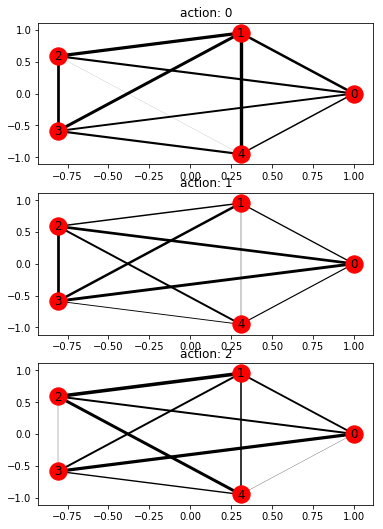

In [212]:
Gs = create_graphs(n, m, P)
plot_mdp(n, m, Gs)

In [213]:
Io = np.kron(np.eye(n), np.ones((1,m)))

In [219]:
v = cvx.Variable((n,1))
gamma = 0.9
p0 = np.ones((n,1))/n

objective = cvx.Minimize((1 - gamma) * p0.T @ v)
constraints = [Io.T @ v >= r + gamma * P.T @ v]
prob = cvx.Problem(objective, constraints)
prob.solve()

value_inf = (r + gamma * P.T @ v.value)
value_inf, value_inf.reshape(m,n).argmax(0)

(array([[5.25191265],
        [5.50409705],
        [5.26924454],
        [5.65777755],
        [5.24805883],
        [5.57077692],
        [5.57983296],
        [5.29569405],
        [5.99751797],
        [5.73928846],
        [5.49882328],
        [5.72839619],
        [5.40714587],
        [5.70583713],
        [6.16637487]]), array([1, 2, 2, 1, 2]))

In [198]:
gamma = 0.9
p0 = np.ones((n,1))/n

y = cvx.Variable((n*m,1))
objective = cvx.Maximize(r.T @ y)
constraints = [ Io @ y == (1 - gamma) * p0 + gamma * P @ y,
                y >= 0]
prob = cvx.Problem(objective, constraints)
prob.solve()

_y = y.value;
_y = _y.round(2).reshape(m,n)

In [220]:
_y / _y.sum(0)[np.newaxis]

/Users/ben/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


array([[        nan,  1.        ,         nan,  0.36842105, -0.        ],
       [        nan, -0.        ,         nan,  0.63157895,  0.45      ],
       [        nan,  0.        ,         nan,  0.        ,  0.55      ]])

In [188]:
p0 = np.ones((n))/n

y = cvx.Variable(n*m)
objective = cvx.Maximize(r.T @ y)
constraints = [Io @ y == P @ y,
               np.ones((n*m,1)).T @ y == 1,
               y >= 0]
prob = cvx.Problem(objective, constraints)
        
prob.solve(verbose=True)
_y = y.value; _y[_y<0] = 0

-----------------------------------------------------------------
           OSQP v0.3.1  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 15, constraints m = 21
          nnz(P) + nnz(A) = 120
settings: linear system solver = suitesparse ldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -1.1566e+01   6.39e+00   9.31e+01   1.00e-01   9.41e-05s
  75  -5.8664e-01   1.94e-03   3.62e-04   1.00e-01   2.07e-04s
plsh  -5.8392e-01   2.66e-17   1.93e-16   --------   3.